In [1]:
import sys

sys.path.append('..')

import LoadData2
import numpy as np

def loadCommon3ScansGendersAges(meta):
    incFn = lambda key, entry: LoadData2.allScansIncFn(entry, ['rest','nback','emoid'])
    kLoadFn = lambda key, entry: key 
    rLoadFn = lambda key, entry: LoadData2.scanLoadFn(entry, 'rest')
    nLoadFn = lambda key, entry: LoadData2.scanLoadFn(entry, 'nback')
    eLoadFn = lambda key, entry: LoadData2.scanLoadFn(entry, 'emoid')
    gLoadFn = lambda key, entry: LoadData2.genderLoadFn(entry, {'M':0, 'F':1})
    aLoadFn = lambda key, entry: LoadData2.ageLoadFn(entry)
    keys = LoadData2.loadFromMeta(meta, incFn, kLoadFn)
    rest = LoadData2.loadFromMeta(meta, incFn, rLoadFn)
    nback = LoadData2.loadFromMeta(meta, incFn, nLoadFn)
    emoid = LoadData2.loadFromMeta(meta, incFn, eLoadFn)
    genders = LoadData2.loadFromMeta(meta, incFn, gLoadFn)
    ages = LoadData2.loadFromMeta(meta, incFn, aLoadFn)
    return keys, np.stack(rest), np.stack(nback), np.stack(emoid), np.array(genders, dtype='long'), np.array(ages)

pncDir = '../../PNC_Good'

meta3 = LoadData2.loadMeta(f'{pncDir}/MegaMeta3.pkl')
keys, rest, nback, emoid, genders, ages = loadCommon3ScansGendersAges(meta3)

print(rest.shape)
print(nback.shape)
print(emoid.shape)
print(genders.shape)
print(ages.shape)

(622, 264, 124)
(622, 264, 231)
(622, 264, 210)
(622,)
(622,)


In [2]:
# Get FC and convert to torch

from LoadData2 import getFC
import torch

# restP = getFC(rest, kind='correlation').reshape([622,264*264])
nbackP = getFC(nback, kind='correlation').reshape([622,264*264])
emoidP = getFC(emoid, kind='correlation').reshape([622,264*264])

# rest_t = torch.from_numpy(rest).float().cuda()
nback_t = torch.from_numpy(nback).float().cuda()
emoid_t = torch.from_numpy(emoid).float().cuda()

print('Done FC')

# restP_t = torch.from_numpy(restP).float().cuda()
nbackP_t = torch.from_numpy(nbackP).float().cuda()
emoidP_t = torch.from_numpy(emoidP).float().cuda()
feat_t = torch.cat([nbackP_t, emoidP_t], dim=1)
genders_t = torch.from_numpy(genders).cuda()
ages_t = torch.from_numpy(ages).float().cuda()

# print(restP_t.shape)
print(nbackP_t.shape)
print(emoidP_t.shape)
print(feat_t.shape)
print(genders_t.shape)
print(ages_t.shape)

Done FC
torch.Size([622, 69696])
torch.Size([622, 69696])
torch.Size([622, 139392])
torch.Size([622])
torch.Size([622])


In [8]:
print(genders[genders == 0].shape)
print(genders[genders == 1].shape)

(279,)
(343,)


In [3]:
# Load splits

import pickle

with open('../../Work/MGIN/Splits.pkl', 'rb') as f:
    d = pickle.load(f)
    
assert d['keys'] == keys, 'Keys not equal'
assert len(d['keys']) == (len(d['groups'][0][0]) + len(d['groups'][0][1])), 'Bad number of subj in splits'

print('Done')

Done


In [21]:
from sklearn.svm import SVC

nCorrect = np.zeros([10])
for i in range(10):
    clf = SVC()
    trainIdcs = np.array(d['groups'][i][0], dtype='int')
    testIdcs = np.array(d['groups'][i][1], dtype='int')
    clf.fit(emoidP[trainIdcs], genders[trainIdcs])
    nCorrect[i] = np.sum(clf.predict(emoidP[testIdcs]) == genders[testIdcs])
    print(f'{i} {nCorrect[i]}')
print(np.sum(nCorrect)/622)


0 52.0
1 41.0
2 44.0
3 34.0
4 40.0
5 40.0
6 43.0
7 45.0
8 38.0
9 46.0
0.680064308681672


In [4]:
def normalize(A):
    if A.shape[0] != A.shape[1]:
        raise Exception("Bad A shape")
    d = torch.sum(A,dim=1)**0.5
    return ((A/d).T/d).T

def cosineSimilarity(a, b): 
    e = torch.einsum('ai,bi->ab',a,b)
    aa = torch.einsum('ai,ai->a',a,a)**0.5
    bb = torch.einsum('bi,bi->b',b,b)**0.5
    e /= aa.unsqueeze(1)
    e /= bb.unsqueeze(1).T
    return e

def cosineSimilarityAdjacency(a, b): 
    return normalize(cosineSimilarity(a,b)-torch.eye(a.shape[0]).float().cuda())

print('Complete')

Complete


In [35]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.dense import DenseGINConv

class GIN(nn.Module):
    def __init__(self):
        super(GIN, self).__init__()
        self.gc1 = DenseGINConv(nn.Linear(264*264,100)).float().cuda()
        self.gc2 = DenseGINConv(nn.Linear(100,2)).float().cuda()
        self.loss = torch.nn.CrossEntropyLoss()
        
    def forward(self, x, A):
        x = F.relu(self.gc1(x,A))
        x = self.gc2(x,A)
        return x
    
nCorrect = np.zeros([10])
for i in range(10):
    trainIdcs = torch.from_numpy(np.array(d['groups'][i][0], dtype='int')).cuda()
    testIdcs = torch.from_numpy(np.array(d['groups'][i][1], dtype='int')).cuda()
    
    gin = GIN()
    optim = torch.optim.Adam(gin.parameters(), lr=1e-5, weight_decay=0.2)
    nEpochs = 3000
    pPeriod = 200
    inp = emoidP_t
    inpTrain = inp[trainIdcs]
    Atrain = cosineSimilarityAdjacency(inp[trainIdcs], inp[trainIdcs])
    A = cosineSimilarityAdjacency(inp, inp)
                                          
    for epoch in range(nEpochs):
        optim.zero_grad()
        pred = gin(inpTrain, Atrain).squeeze()
        loss = gin.loss(pred, genders_t[trainIdcs])
        loss.backward()
        optim.step()
        if (epoch % pPeriod == 0 or epoch == nEpochs-1):
            print(f'epoch {epoch} loss={loss}')
            
    nCorrect[i] = int(torch.sum(torch.argmax(gin(inp, A).squeeze(), dim=1)[testIdcs] == genders_t[testIdcs]))
    print(f'{i} {nCorrect[i]}')
    
print(np.sum(nCorrect)/622)
        

epoch 0 loss=0.6939981579780579
epoch 200 loss=0.529750645160675
epoch 400 loss=0.4170106053352356
epoch 600 loss=0.34954604506492615
epoch 800 loss=0.30459854006767273
epoch 1000 loss=0.2721986770629883
epoch 1200 loss=0.2550598978996277
epoch 1400 loss=0.23435655236244202
epoch 1600 loss=0.2222174108028412
epoch 1800 loss=0.20877614617347717
epoch 2000 loss=0.20517244935035706
epoch 2200 loss=0.19080863893032074
epoch 2400 loss=0.1837873011827469
epoch 2600 loss=0.17903412878513336
epoch 2800 loss=0.17095795273780823
epoch 2999 loss=0.166261225938797
0 52.0
epoch 0 loss=0.7304056882858276
epoch 200 loss=0.5835260152816772
epoch 400 loss=0.47567084431648254
epoch 600 loss=0.38355255126953125
epoch 800 loss=0.33260488510131836
epoch 1000 loss=0.29629141092300415
epoch 1200 loss=0.274698406457901
epoch 1400 loss=0.2573455572128296
epoch 1600 loss=0.23761676251888275
epoch 1800 loss=0.22599823772907257
epoch 2000 loss=0.2144373059272766
epoch 2200 loss=0.20457173883914948
epoch 2400 loss

In [58]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2*264*264,100).float().cuda()
        self.fc2 = nn.Linear(100,2).float().cuda()
        self.loss = torch.nn.CrossEntropyLoss()
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
nCorrect = np.zeros([10])
for i in range(10):
    trainIdcs = torch.from_numpy(np.array(d['groups'][i][0], dtype='int')).cuda()
    testIdcs = torch.from_numpy(np.array(d['groups'][i][1], dtype='int')).cuda()
    
    mlp = MLP()
    optim = torch.optim.Adam(mlp.parameters(), lr=1e-5, weight_decay=0)
    nEpochs = 2000
    pPeriod = 200
    inp = torch.cat([torch.stack(wNback), torch.stack(w)], dim=1).reshape(622,2*264*264)
    inpTrain = inp[trainIdcs]
                                          
    for epoch in range(nEpochs):
        optim.zero_grad()
        pred = mlp(inpTrain).squeeze()
        loss = mlp.loss(pred, genders_t[trainIdcs])
        loss.backward()
        optim.step()
        if (epoch % pPeriod == 0 or epoch == nEpochs-1):
            print(f'epoch {epoch} loss={loss}')
            
    nCorrect[i] = int(torch.sum(torch.argmax(mlp(inp[testIdcs]).squeeze(), dim=1) == genders_t[testIdcs]))
    print(f'{i} {nCorrect[i]}')
    
print(np.sum(nCorrect)/622)
        

epoch 0 loss=0.6898373365402222
epoch 200 loss=0.46200576424598694
epoch 400 loss=0.30350279808044434
epoch 600 loss=0.2003946304321289
epoch 800 loss=0.13526006042957306
epoch 1000 loss=0.09406688809394836
epoch 1200 loss=0.0674828365445137
epoch 1400 loss=0.04982450604438782
epoch 1600 loss=0.037727680057287216
epoch 1800 loss=0.02919282391667366
epoch 1999 loss=0.023034462705254555
0 54.0
epoch 0 loss=0.7050179243087769
epoch 200 loss=0.5324627161026001
epoch 400 loss=0.3902231752872467
epoch 600 loss=0.27998676896095276
epoch 800 loss=0.1999693065881729
epoch 1000 loss=0.14395137131214142
epoch 1200 loss=0.10522746294736862
epoch 1400 loss=0.07836645841598511
epoch 1600 loss=0.059489138424396515
epoch 1800 loss=0.04598424956202507
epoch 1999 loss=0.036176588386297226
1 52.0
epoch 0 loss=0.6923713088035583
epoch 200 loss=0.4825572967529297
epoch 400 loss=0.3256909251213074
epoch 600 loss=0.21853964030742645
epoch 800 loss=0.1487041562795639
epoch 1000 loss=0.10370099544525146
epoch 

In [76]:
# GCN

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.dense import DenseGCNConv

class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.gc1 = DenseGCNConv(2*264*264,100).float().cuda()
        self.gc2 = DenseGCNConv(100,2).float().cuda()
        self.loss = torch.nn.CrossEntropyLoss()
        
    def forward(self, x, A):
        x = F.relu(self.gc1(x,A))
        x = self.gc2(x,A)
        return x
    
nCorrect = np.zeros([10])
for i in range(10):
    trainIdcs = torch.from_numpy(np.array(d['groups'][i][0], dtype='int')).cuda()
    testIdcs = torch.from_numpy(np.array(d['groups'][i][1], dtype='int')).cuda()
    
    gcn = GCN()
    optim = torch.optim.Adam(gcn.parameters(), lr=1e-5, weight_decay=0.2)
    nEpochs = 3000
    pPeriod = 200
    inp = feat_t
    inpTrain = inp[trainIdcs]
    Atrain = cosineSimilarityAdjacency(inp[trainIdcs], inp[trainIdcs])
    A = cosineSimilarityAdjacency(inp, inp)
                                          
    for epoch in range(nEpochs):
        optim.zero_grad()
        pred = gcn(inpTrain, Atrain).squeeze()
        loss = gcn.loss(pred, genders_t[trainIdcs])
        loss.backward()
        optim.step()
        if (epoch % pPeriod == 0 or epoch == nEpochs-1):
            print(f'epoch {epoch} loss={loss}')
            
    nCorrect[i] = int(torch.sum(torch.argmax(gcn(inp, A).squeeze(), dim=1)[testIdcs] == genders_t[testIdcs]))
    print(f'{i} {nCorrect[i]}')
    
print(np.sum(nCorrect)/622)
        

epoch 0 loss=0.7134140729904175
epoch 200 loss=0.5816420316696167
epoch 400 loss=0.4816780388355255
epoch 600 loss=0.40955573320388794
epoch 800 loss=0.36126694083213806
epoch 1000 loss=0.32267287373542786
epoch 1200 loss=0.3065274953842163
epoch 1400 loss=0.2903484106063843
epoch 1600 loss=0.28322240710258484
epoch 1800 loss=0.2781234383583069
epoch 2000 loss=0.274154931306839
epoch 2200 loss=0.27265647053718567
epoch 2400 loss=0.2721119225025177
epoch 2600 loss=0.27066510915756226
epoch 2800 loss=0.27017900347709656
epoch 2999 loss=0.2704913318157196
0 56.0
epoch 0 loss=0.6897611021995544
epoch 200 loss=0.5296152234077454
epoch 400 loss=0.4209907650947571
epoch 600 loss=0.35654231905937195
epoch 800 loss=0.31553706526756287
epoch 1000 loss=0.2920926809310913
epoch 1200 loss=0.28222233057022095
epoch 1400 loss=0.2687660753726959
epoch 1600 loss=0.26373210549354553
epoch 1800 loss=0.26094862818717957
epoch 2000 loss=0.2592127025127411
epoch 2200 loss=0.25922346115112305
epoch 2400 loss

In [146]:
# GIN

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.dense import DenseGINConv

class GIN(nn.Module):
    def __init__(self):
        super(GIN, self).__init__()
        self.gc1 = DenseGINConv(nn.Linear(2*264*264,100)).float().cuda()
        self.gc2 = DenseGINConv(nn.Linear(100,2)).float().cuda()
        self.loss = torch.nn.CrossEntropyLoss()
        
    def forward(self, x, A):
        x = F.relu(self.gc1(x,A))
        x = self.gc2(x,A)
        return x
    
    
ageIdcs = np.flatnonzero((ages > 18)*(ages <= 23))
    
nCorrect = np.zeros([10])
for i in range(1):
#     trainIdcs = np.array(d['groups'][i][0], dtype='int')
#     testIdcs = np.array(d['groups'][i][1], dtype='int')
    
#     trainIdcs = np.intersect1d(trainIdcs, ageIdcs)
#     testIdcs = np.intersect1d(testIdcs, ageIdcs)
    
#     trainIdcs = torch.from_numpy(trainIdcs).cuda()
#     testIdcs = torch.from_numpy(testIdcs).cuda()
#     allIdcs = torch.cat([trainIdcs, testIdcs])
    trainIdcs = torch.from_numpy(ageIdcs).cuda()
    testIdcs = torch.from_numpy(ageIdcs).cuda()
    allIdcs = torch.from_numpy(ageIdcs).cuda()
    
    gin = GIN()
    optim = torch.optim.Adam(gin.parameters(), lr=1e-5, weight_decay=0.2)
    nEpochs = 3000
    pPeriod = 200
#     inp = torch.cat([torch.stack(wNback), torch.stack(w)], dim=1).reshape(622,2*264*264)
    inp = feat_t
    inpTrain = inp[trainIdcs]
    Atrain = cosineSimilarityAdjacency(inp[trainIdcs], inp[trainIdcs])
    A = cosineSimilarityAdjacency(inp[allIdcs], inp[allIdcs])
                                          
    for epoch in range(nEpochs):
        optim.zero_grad()
        pred = gin(inpTrain, Atrain).squeeze()
        loss = gin.loss(pred, genders_t[trainIdcs])
        loss.backward()
        optim.step()
        if (epoch % pPeriod == 0 or epoch == nEpochs-1):
            print(f'epoch {epoch} loss={loss}')
            
    nCorrect[i] = int(torch.sum(torch.argmax(gin(inp[allIdcs], A).squeeze(), dim=1) 
                                == genders_t[testIdcs]))
    print(f'{i} {nCorrect[i]}')
    
print(np.sum(nCorrect)/ageIdcs.shape[0])
        

epoch 0 loss=0.6686932444572449
epoch 200 loss=0.4193781316280365
epoch 400 loss=0.1884927749633789
epoch 600 loss=0.12549814581871033
epoch 800 loss=0.10553589463233948
epoch 1000 loss=0.09246329963207245
epoch 1200 loss=0.08504592627286911
epoch 1400 loss=0.07869315147399902
epoch 1600 loss=0.07488855719566345
epoch 1800 loss=0.07103140652179718
epoch 2000 loss=0.06868622452020645
epoch 2200 loss=0.06540092825889587
epoch 2400 loss=0.061802804470062256
epoch 2600 loss=0.060195062309503555
epoch 2800 loss=0.058560654520988464
epoch 2999 loss=0.10099808126688004
0 141.0
1.0


In [85]:
from scipy import stats

onesA = int(80.06/100*622)
zerosA = 622-onesA

onesA = np.ones(onesA)
zerosA = np.zeros(zerosA)

onesB = int(82.15/100*622)
zerosB = 622-onesB

onesB = np.ones(onesB)
zerosB = np.zeros(zerosB)

A = np.concatenate([onesA, zerosA])
B = np.concatenate([onesB, zerosB])

stats.ttest_ind(A, B)

Ttest_indResult(statistic=-0.9381430454277387, pvalue=0.34835329839874707)

In [58]:
from scipy.stats import t

2*(1-t.cdf(2*(0.791-0.6865), 1, scale=4/622))

0.01958242356317652

In [53]:
t.cdf(0.3,1000,scale=2/1000**0.5)

0.9999987966479774

In [47]:
import math

mycon = emoid_t
alpha = 3
prevErr = math.inf

myconAug = torch.stack([torch.cat([A.T, alpha*torch.eye(264).float().cuda()]) for A in mycon])
w = 622*[torch.zeros(264,264).float().cuda()]

for epoch in range(10):
    wMean = torch.mean(torch.stack(w),axis=0)
    err = 0
    for i in range(622):
        A = mycon[i].T
        B = torch.cat([A, wMean])
        w[i],_,_,_ = torch.linalg.lstsq(myconAug[i],B)
        err += torch.sum(torch.abs(myconAug[i]@w[i]-B))
    print(f'Finished {epoch} error={err}')
    if err >= prevErr:
        break
    prevErr = err
    
print('Complete')

Finished 0 error=2065016.375
Finished 1 error=1940784.0
Finished 2 error=1918525.875
Finished 3 error=1913132.75
Finished 4 error=1911699.875
Finished 5 error=1911301.5
Finished 6 error=1911188.5
Finished 7 error=1911153.75
Finished 8 error=1911143.375
Finished 9 error=1911140.625
Complete


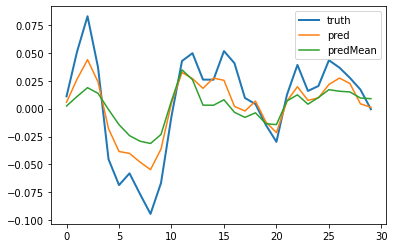

In [53]:
import matplotlib.pyplot as plt

sub = 2

A = (mycon[sub].T@wNback[sub]).detach().cpu().numpy()
B = (mycon[sub].T@wMean).detach().cpu().numpy()

plt.plot(nback[sub,3,0:30],label='truth',linewidth=2)
plt.plot(A[0:30,3],label='pred')
plt.plot(B[0:30,3],label='predMean')
plt.legend()
plt.show()

In [55]:
import math

mycon = nback_t
alpha = 3
prevErr = math.inf

myconAug = torch.stack([torch.cat([A.T, alpha*torch.eye(264).float().cuda()]) for A in mycon])
wNback = 622*[torch.zeros(264,264).float().cuda()]

for epoch in range(10):
    wMean = torch.mean(torch.stack(wNback),axis=0)
    err = 0
    for i in range(622):
        A = mycon[i].T
        B = torch.cat([A, wMean])
        wNback[i],_,_,_ = torch.linalg.lstsq(myconAug[i],B)
        err += torch.sum(torch.abs(myconAug[i]@wNback[i]-B))
    print(f'Finished {epoch} error={err}')
    if err >= prevErr:
        break
    prevErr = err
    
print('Complete')

Finished 0 error=2164109.5
Finished 1 error=2034239.0
Finished 2 error=2010652.5
Finished 3 error=2004884.625
Finished 4 error=2003344.375
Finished 5 error=2002916.25
Finished 6 error=2002793.0
Finished 7 error=2002757.25
Finished 8 error=2002746.125
Finished 9 error=2002743.25
Complete


In [151]:
class Explainer(nn.Module):
    def __init__(self, nSub):
        super(Explainer, self).__init__()
        self.fmask = nn.Parameter(torch.ones(2*264*264).float().cuda())
        self.Amask = nn.Parameter(torch.ones(nSub,nSub).float().cuda())

    def forward(self, x):
        fmask = torch.sigmoid(self.fmask)
        Amask = torch.sigmoid(self.Amask)
        xm = x*fmask
        A = cosineSimilarityAdjacency(xm, xm)
        return gin(xm, A*Amask).squeeze()

    def loss(self, pred, truth):
        loss = 0
        fm = torch.sigmoid(self.fmask)
        Am = torch.sigmoid(self.Amask)
        predLoss = gin.loss(pred, truth)
        featSizeLoss = torch.mean(fm)
        featEntLoss = torch.mean(-fm*torch.log(fm) - (1-fm)*torch.log(1-fm))
        popSizeLoss = torch.mean(Am)
        popEntLoss = torch.mean(-Am*torch.log(Am) - (1-Am)*torch.log(1-Am))
        loss += self.HP['predl']*predLoss + self.HP['fsl']*featSizeLoss + self.HP['fel']*featEntLoss
        loss += self.HP['psl']*popSizeLoss + self.HP['pel']*popEntLoss
        return loss

# exp = Explainer(5)
# exp.load_state_dict(torch.load('../../Work/Explainer/ExpB_NoGroupLoss.pyt'))
# exp.eval()

nEpoch = 150
pPrint = 20

HP = {
    'predl': 1,
    'fsl': 5,
    'fel': 2,
    'psl': 0,
    'pel': 1000
}

allIdcs = torch.from_numpy(np.intersect1d(np.flatnonzero(genders == 1), ageIdcs)).cuda()
exp = Explainer(allIdcs.shape[0])
optim = torch.optim.Adam(exp.parameters(), lr=5e-1, weight_decay=0)

exp.HP = HP

for epoch in range(nEpoch):
    optim.zero_grad()
    pred = exp(inp[allIdcs])
    loss = exp.loss(pred, genders_t[allIdcs])
    loss.backward()
    optim.step()
    if epoch % pPrint == 0 or epoch == nEpoch-1:
        print(f'epoch {epoch} loss={loss}')

print('Complete')
print(torch.sum(torch.argmax(pred, dim=1) == genders_t[allIdcs])/genders_t[allIdcs].shape[0])
print(allIdcs.shape[0])

epoch 0 loss=587.0391845703125
epoch 20 loss=3.2672598361968994
epoch 40 loss=0.9199151992797852
epoch 60 loss=0.7076492309570312
epoch 80 loss=0.6367939710617065
epoch 100 loss=0.5854008197784424
epoch 120 loss=0.541902482509613
epoch 140 loss=0.5016167163848877
epoch 149 loss=0.48562347888946533
Complete
tensor(1., device='cuda:0')
88


In [30]:
import numpy as np

roiMap1 = np.zeros(265,dtype='int')
roiMap2 = np.zeros(265,dtype='int')
revMap2 = np.zeros(264,dtype='int')
roiNames = {}
borders1 = []
borders2 = []

with open('../../PNC/PP264_template.csv', 'r') as f:
    lines = f.readlines()
    for i in range(2,len(lines)):
        line = lines[i].split(',')
        area = int(line[11])
        r1 = int(line[0])
        r2 = int(line[1])
        name = line[14].strip()
        roiMap1[r1] = area
        roiMap2[r2] = area
        roiNames[area] = name
        revMap2[r1-1] = r2-1
#         print([area, r1, r2, name])

last1 = roiMap1[1]
last2 = roiMap2[1]
for i in range(2,265):
    if roiMap1[i] != last1:
        borders1.append(i)
        last1 = roiMap1[i]
    if roiMap2[i] != last2:
        borders2.append(i)
        last2 = roiMap2[i]
    
borders1 = [0] + borders1 + [264]
print(borders1)
print(borders2)

[0, 31, 36, 50, 63, 121, 126, 157, 182, 200, 213, 222, 233, 237, 264]
[13, 42, 47, 61, 74, 84, 86, 132, 133, 137, 138, 139, 140, 143, 174, 182, 186, 203, 221, 222, 235, 243, 247, 251, 253, 255, 256]


In [75]:
def topK(msk, q):
    mskq = np.quantile(msk, q)
    msk[msk < mskq] = 0
    msk[msk >= mskq] = 1
    assert np.sum(msk) == round((1-q)*msk.size), 'Error in topK'
    return msk

def maskDiag(A):
    if A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise Exception('bad A shape')
    return A*(1-np.eye(A.shape[0]))

def rearrange(p,idcs):
    return p[:,idcs][idcs]

def processMask(rawMask, idx, q):
    msk = rawMask[idx*264*264:(idx+1)*264*264]
    msk = torch.sigmoid(msk).detach().cpu().numpy()
    msk = maskDiag(msk.reshape(264,264))
    msk = topK(msk, q)
    msk = rearrange(msk,revMap2)
    return msk

print('Complete')

Complete


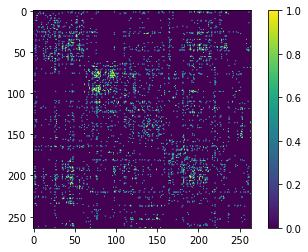

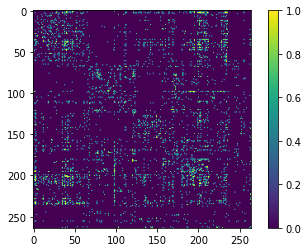

In [152]:
import matplotlib.pyplot as plt

plt.imshow(processMask(exp.fmask, 0, 0.95))
plt.colorbar()
plt.show()

plt.imshow(processMask(exp.fmask, 1, 0.95))
plt.colorbar()
plt.show()

In [153]:
def getTopSystems(binfc, n):
    L = int(15*14/2)
    keys = np.zeros([L,2])
    vals = np.zeros(L)
    idx = 0
    for i in range(14):
        i0 = borders1[i]
        i1 = borders1[i+1]
        for j in range(i,14):
            j0 = borders1[j]
            j1 = borders1[j+1]
            s = np.sum(binfc[i0:i1,j0:j1])
            keys[idx][0] = i
            keys[idx][1] = j
            vals[idx] = s
            idx += 1
    idcs = np.argsort(vals)
    return keys[idcs][::-1,:][0:n,:], vals[idcs][::-1][0:n]

def prettyPrintSystems(sysRes, title):
    lookup = ["SM Hand", "SM Mouth", "CNG", "AUD", "DMN", "MEM", "VIS", "FRNT", "SAL", "SUB", "VTRL", "DRSL", "CB", "UNK"]
    keys = sysRes[0].astype(int)
    vals = sysRes[1].astype(int)
    print(title)
    for i in range(keys.shape[0]):
        print(f'{lookup[keys[i,0]]}-{lookup[keys[i,1]]} {vals[i]}')

ageLabels = ["8-12", "12-14", "14-16", "16-18", "18-22"]

prettyPrintSystems(getTopSystems(processMask(exp.fmask, 0, 0.95), 5), '8-12yo female nback')
prettyPrintSystems(getTopSystems(processMask(exp.fmask, 1, 0.95), 5), '8-12yo female emoid')

8-12yo female nback
DMN-DMN 412
VIS-VIS 101
DMN-VIS 94
SM Hand-SM Hand 83
DMN-FRNT 63
8-12yo female emoid
DMN-DMN 221
VIS-VIS 95
SM Hand-SM Hand 92
DMN-FRNT 87
SM Hand-SUB 65


In [154]:
# Save mask

with open('../../Work/MGIN/Masks/FemaleAgeGroup4.pkl', 'wb') as f:
    pickle.dump(exp.fmask.detach().cpu(), f)